In [1]:
import csv
import nltk
from whoosh.fields import Schema, TEXT, ID

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meriem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


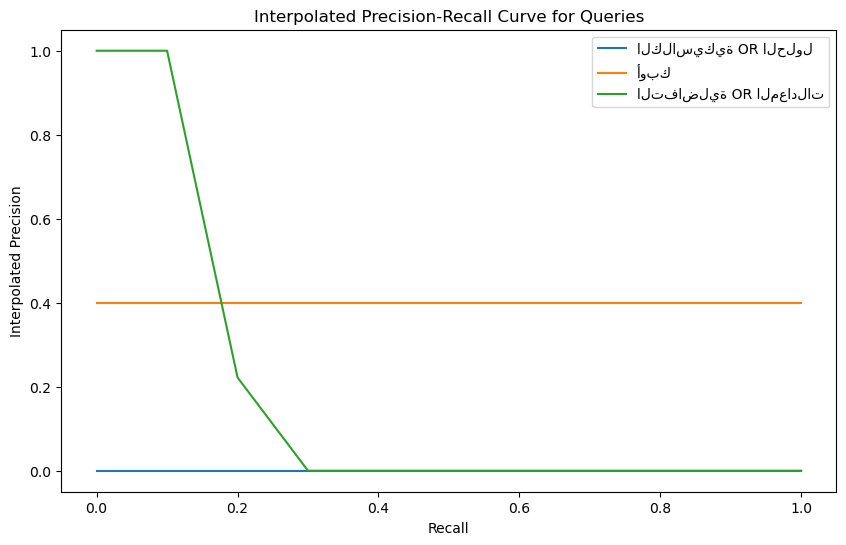

In [4]:
import csv
from whoosh.fields import Schema, TEXT, ID
from whoosh import index
from whoosh.analysis import RegexTokenizer, StopFilter, Filter
from whoosh.qparser import QueryParser
from nltk.stem.isri import ISRIStemmer
import os.path
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt

nltk.download('stopwords')

# Charger la liste des mots vides en arabe de NLTK
arabic_stopwords = set(stopwords.words("arabic"))

class ArabicStemFilter(Filter):
    def __init__(self):
        self.stemmer = ISRIStemmer()

    def __call__(self, tokens):
        for t in tokens:
            t.text = self.stemmer.stem(t.text)
            yield t

# Créer un analyseur personnalisé avec la liste des mots vides de NLTK
analyzer = RegexTokenizer() | StopFilter(stoplist=arabic_stopwords) | ArabicStemFilter()

# Créer le schéma en utilisant l'analyseur personnalisé
schema = Schema(
    title=TEXT(stored=True),
    path=ID(stored=True),
    content=TEXT(stored=True, analyzer=analyzer, vector=True)  # Ajouter "vector=True"
)

# Créer le répertoire d'index s'il n'existe pas
#if not os.path.exists("Index"):
 #   os.mkdir("Index")

# Lister les fichiers dans le répertoire "Corpus"
corpus_dir = "E:/M2/RI/Corpus/Corpus"
file_names = os.listdir(corpus_dir)

# Créer l'index avec le modèle BM25F
ix = index.create_in("Index-2", schema)  

# Indexer les documents avec prétraitement
with ix.writer() as writer:
    for file_name in file_names:
        with open(os.path.join(corpus_dir, file_name), 'r', encoding='windows-1256') as file:
            content = file.read()
            writer.add_document(title=file_name, content=content, path='')


def search_vectorial(query_str, relevant_documents, limit=20):
    with ix.searcher() as searcher:
        # Définir un analyseur et un parseur liés à l'index
        query_parser = QueryParser("content", ix.schema)
        query = query_parser.parse(query_str)

        # Recherche Vectorielle (utilisation par défaut de Whoosh)
        results_vectorial = searcher.search(query, terms=True, limit=limit)

        # Marquer les résultats en fonction de la liste des documents pertinents
        marked_results = []
        true_positives = 0  # Count of relevant documents retrieved
        false_positives = 0  # Count of irrelevant documents retrieved
        total_relevant_documents = len(relevant_documents)

        if total_relevant_documents == 0:
            recall = precision = 0
        else:
            for rank, r in enumerate(results_vectorial, start=1):
                is_relevant = r['title'] in relevant_documents
                mark = 'YES' if is_relevant else 'NO'

                # Calculate recall and precision for each document
                if is_relevant:
                    true_positives += 1
                else:
                    false_positives += 1

                recall = round(true_positives / total_relevant_documents, 3)
                precision = round(true_positives / (true_positives + false_positives), 3)

                # Append information to the marked result
                marked_results.append((rank, r['title'], mark, recall, precision))

        # Write detailed results to CSV
        csv_file_path = f"results_{query_str.replace(' ', '_')}.csv"
        with open(csv_file_path, mode='w', encoding='utf-8', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow(['Rang', 'document', 'Pertinent', 'Rappel', 'Precision'])
            csv_writer.writerows(marked_results)

        return marked_results

def calculate_interpolated_precision(results, recall_levels):
    recall_values = [result[3] for result in results]
    precision_values = [result[4] for result in results]

    interpolated_precisions = []
    for recall_level in recall_levels:
        max_precision = 0
        for recall, precision in zip(recall_values, precision_values):
            if recall >= recall_level:
                max_precision = max(max_precision, precision)
        interpolated_precisions.append(max_precision)

    return interpolated_precisions

# Define the queries and relevant documents for each query
queries = [
    ("الكلاسيكية OR الحلول", []),
    ("أوبك", ["D493 A.txt", "D330 A.txt"]),
    ("التفاضلية OR المعادلات", ["D508 A.txt", "D081 A.txt", "D105 A.txt", "D162 A.txt", "D329 A.txt", "D552 A.txt", "D464 A.txt"])
]

# Interpolated Precision Recall Curve
recall_levels = np.arange(0, 1.1, 0.1)
interpolated_precision_all_queries = []

# Rechercher et marquer les documents pertinents pour chaque requête
for query, relevant_documents in queries:
    marked_results_query = search_vectorial(query, relevant_documents, limit=20)
    interpolated_precision_query = calculate_interpolated_precision(marked_results_query, recall_levels)
    interpolated_precision_all_queries.append((query, interpolated_precision_query))

# Plot Interpolated Precision Recall Curve for all queries
plt.figure(figsize=(10, 6))
for query, interpolated_precision_query in interpolated_precision_all_queries:
    plt.plot(recall_levels, interpolated_precision_query, label=query)

plt.title('Interpolated Precision-Recall Curve for Queries')
plt.xlabel('Recall')
plt.ylabel('Interpolated Precision')
plt.legend()
plt.show()


In [32]:
import pandas as pd

# Provide the correct file path as a string
file_path = r'C:\Users\meriem\Documents\results_التفاضلية_OR_المعادلات.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Print the DataFrame
print(df)


    Rang    document Pertinent  Rappel  Precision
0      1  D162 A.txt       YES   0.143      1.000
1      2  D185 A.txt        NO   0.143      0.500
2      3  D334 A.txt        NO   0.143      0.333
3      4  D471 A.txt        NO   0.143      0.250
4      5  D468 A.txt        NO   0.143      0.200
5      6  D250 A.txt        NO   0.143      0.167
6      7  D560 A.txt        NO   0.143      0.143
7      8  D359 A.txt        NO   0.143      0.125
8      9  D329 A.txt       YES   0.286      0.222
9     10  D139 A.txt        NO   0.286      0.200
10    11  D264 A.txt        NO   0.286      0.182
11    12  D325 A.txt        NO   0.286      0.167
12    13  D062 A.txt        NO   0.286      0.154
13    14  D225 A.txt        NO   0.286      0.143
14    15  D551 A.txt        NO   0.286      0.133
15    16  D241 A.txt        NO   0.286      0.125
16    17  D568 A.txt        NO   0.286      0.118
17    18  D066 A.txt        NO   0.286      0.111
18    19  D289 A.txt        NO   0.286      0.105


In [35]:
import pandas as pd

# Provide the correct file path as a string
file_path = r'C:\Users\meriem\Documents\results_أوبك.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Print the DataFrame
print(df)


   Rang    document Pertinent  Rappel  Precision
0     1  D030 A.txt        NO     0.0      0.000
1     2  D345 A.txt        NO     0.0      0.000
2     3  D493 A.txt       YES     0.5      0.333
3     4  D455 A.txt        NO     0.5      0.250
4     5  D330 A.txt       YES     1.0      0.400
5     6  D443 A.txt        NO     1.0      0.333


In [34]:
import pandas as pd

# Provide the correct file path as a string
file_path = r'C:\Users\meriem\Documents\results_الكلاسيكية_OR_الحلول.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Print the DataFrame
print(df)


Empty DataFrame
Columns: [Rang, document, Pertinent, Rappel, Precision]
Index: []


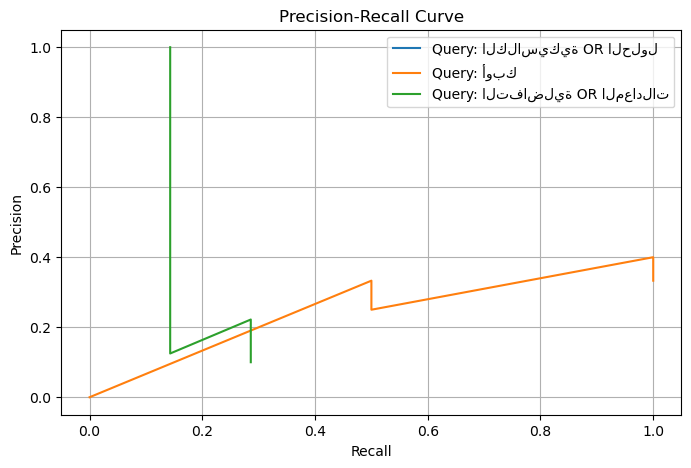

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the Precision-Recall Curve
def plot_precision_recall_curve(results, query):
    recalls = [result[3] for result in results]
    precisions = [result[4] for result in results]

    plt.plot(recalls, precisions, label=f'Query: {query}')

# Define the queries and relevant documents for each query
queries = [
    ("الكلاسيكية OR الحلول", []),
    ("أوبك", ["D493 A.txt", "D330 A.txt"]),
    ("التفاضلية OR المعادلات", ["D508 A.txt", "D081 A.txt", "D105 A.txt", "D162 A.txt", "D329 A.txt", "D552 A.txt", "D464 A.txt"])
]

# Plot non-interpolated Precision-Recall Curve for each query
plt.figure(figsize=(8, 5))
for query, relevant_documents in queries:
    marked_results_query = search_vectorial(query, relevant_documents, limit=20)
    plot_precision_recall_curve(marked_results_query, query)

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
def calculate_average_precision(results):
    precision_values = [result[4] for result in results if result[3] > 0]  # Exclude queries with zero recall
    if not precision_values:
        return 0
    return sum(precision_values) / len(precision_values)

def calculate_f_measure(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)


# Calculate average precision, F-measure, and precision at specific points
average_precisions = []
f_measures = []
precisions_at_points = {"P5": [], "P10": [], "P15": [], "P20": []}

for query, relevant_documents in queries:
    marked_results_query = search_vectorial(query, relevant_documents, limit=20)
    
    recall_values = [result[3] for result in marked_results_query]
    precision_values = [result[4] for result in marked_results_query]
    
    if recall_values and precision_values:
        average_precisions.append(calculate_average_precision(marked_results_query))
        f_measures.append(calculate_f_measure(precision_values[-1], recall_values[-1]))

        precisions_at_points["P5"].append(precision_values[min(4, len(precision_values)-1)])
        precisions_at_points["P10"].append(precision_values[min(9, len(precision_values)-1)])
        precisions_at_points["P15"].append(precision_values[min(14, len(precision_values)-1)])
        precisions_at_points["P20"].append(precision_values[min(19, len(precision_values)-1)])
    else:
        print(f"No results for query: '{query}'")

# ...


# Calculate overall averages
average_precision_overall = sum(average_precisions) / len(average_precisions)
f_measure_overall = sum(f_measures) / len(f_measures)
precision_at_points_overall = {point: sum(values) / len(values) for point, values in precisions_at_points.items()}

# Print the results
print('--------------------')
print(f"Average Precision: {average_precision_overall:.3f}")
print(f"F-measure: {f_measure_overall:.3f}")
print("Precision at specific points:")
for point, value in precision_at_points_overall.items():
    print(f"{point}: {value:.3f}")


No results for query: 'الكلاسيكية OR الحلول'
--------------------
Average Precision: 0.276
F-measure: 0.324
Precision at specific points:
P5: 0.300
P10: 0.267
P15: 0.233
P20: 0.217


-----------------------------------------------------reformulation automatique--------------------------------------------------

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meriem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


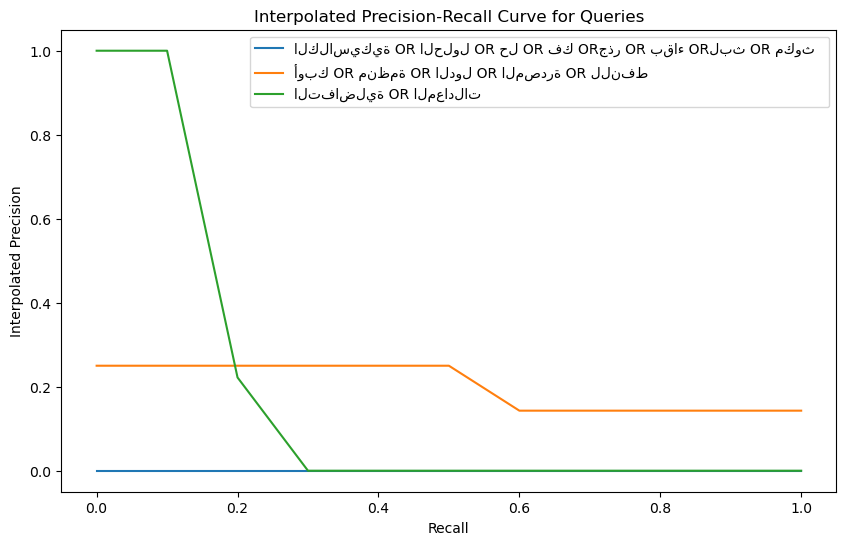

In [42]:
import csv
from whoosh.fields import Schema, TEXT, ID
from whoosh import index
from whoosh.analysis import RegexTokenizer, StopFilter, Filter
from whoosh.qparser import QueryParser
from nltk.stem.isri import ISRIStemmer
import os.path
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt

nltk.download('stopwords')

# Charger la liste des mots vides en arabe de NLTK
arabic_stopwords = set(stopwords.words("arabic"))

class ArabicStemFilter(Filter):
    def __init__(self):
        self.stemmer = ISRIStemmer()

    def __call__(self, tokens):
        for t in tokens:
            t.text = self.stemmer.stem(t.text)
            yield t

# Créer un analyseur personnalisé avec la liste des mots vides de NLTK
analyzer = RegexTokenizer() | StopFilter(stoplist=arabic_stopwords) | ArabicStemFilter()

# Créer le schéma en utilisant l'analyseur personnalisé
schema = Schema(
    title=TEXT(stored=True),
    path=ID(stored=True),
    content=TEXT(stored=True, analyzer=analyzer, vector=True)  # Ajouter "vector=True"
)

# Créer le répertoire d'index s'il n'existe pas
#if not os.path.exists("Index"):
 #   os.mkdir("Index")

# Lister les fichiers dans le répertoire "Corpus"
corpus_dir = "E:/M2/RI/Corpus/Corpus"
file_names = os.listdir(corpus_dir)

# Créer l'index avec le modèle BM25F
ix = index.create_in("Index-2", schema)  # Ajouter le paramètre weighting ici

# Indexer les documents avec prétraitement
with ix.writer() as writer:
    for file_name in file_names:
        with open(os.path.join(corpus_dir, file_name), 'r', encoding='windows-1256') as file:
            content = file.read()
            writer.add_document(title=file_name, content=content, path='')

# ...

# ...

# ...

# ...

def search_vectorial(query_str, relevant_documents, limit=20):
    with ix.searcher() as searcher:
        # Définir un analyseur et un parseur liés à l'index
        query_parser = QueryParser("content", ix.schema)
        query = query_parser.parse(query_str)

        # Recherche Vectorielle (utilisation par défaut de Whoosh)
        results_vectorial = searcher.search(query, terms=True, limit=limit)

        # Marquer les résultats en fonction de la liste des documents pertinents
        marked_results = []
        true_positives = 0  # Count of relevant documents retrieved
        false_positives = 0  # Count of irrelevant documents retrieved
        total_relevant_documents = len(relevant_documents)

        if total_relevant_documents == 0:
            recall = precision = 0
        else:
            for rank, r in enumerate(results_vectorial, start=1):
                is_relevant = r['title'] in relevant_documents
                mark = 'YES' if is_relevant else 'NO'

                # Calculate recall and precision for each document
                if is_relevant:
                    true_positives += 1
                else:
                    false_positives += 1

                recall = round(true_positives / total_relevant_documents, 3)
                precision = round(true_positives / (true_positives + false_positives), 3)

                # Append information to the marked result
                marked_results.append((rank, r['title'], mark, recall, precision))

        # Write detailed results to CSV
        csv_file_path = f"results_{query_str.replace(' ', '_')}.csv"
        with open(csv_file_path, mode='w', encoding='utf-8', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow(['Rang', 'document', 'Pertinent', 'Rappel', 'Precision'])
            csv_writer.writerows(marked_results)

        return marked_results

# ...



def calculate_interpolated_precision(results, recall_levels):
    recall_values = [result[3] for result in results]
    precision_values = [result[4] for result in results]

    interpolated_precisions = []
    for recall_level in recall_levels:
        max_precision = 0
        for recall, precision in zip(recall_values, precision_values):
            if recall >= recall_level:
                max_precision = max(max_precision, precision)
        interpolated_precisions.append(max_precision)

    return interpolated_precisions

# Define the queries and relevant documents for each query
queries = [
    ("الكلاسيكية OR الحلول OR حل OR فك ORجذر OR بقاء ORلبث OR مكوث  ", []),
    ("أوبك OR منظمة OR الدول OR المصدرة OR للنفط ", ["D493 A.txt", "D330 A.txt"]),
    ("التفاضلية OR المعادلات", ["D508 A.txt", "D081 A.txt", "D105 A.txt", "D162 A.txt", "D329 A.txt", "D552 A.txt", "D464 A.txt"])
]

# Interpolated Precision Recall Curve
recall_levels = np.arange(0, 1.1, 0.1)
interpolated_precision_all_queries = []

# Rechercher et marquer les documents pertinents pour chaque requête
for query, relevant_documents in queries:
    marked_results_query = search_vectorial(query, relevant_documents, limit=20)
    interpolated_precision_query = calculate_interpolated_precision(marked_results_query, recall_levels)
    interpolated_precision_all_queries.append((query, interpolated_precision_query))

# Plot Interpolated Precision Recall Curve for all queries
plt.figure(figsize=(10, 6))
for query, interpolated_precision_query in interpolated_precision_all_queries:
    plt.plot(recall_levels, interpolated_precision_query, label=query)

plt.title('Interpolated Precision-Recall Curve for Queries')
plt.xlabel('Recall')
plt.ylabel('Interpolated Precision')
plt.legend()
plt.show()


In [43]:

# Provide the correct file path as a string
file_path = r'C:\Users\meriem\Documents\results_التفاضلية_OR_المعادلات.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Print the DataFrame
print(df)


    Rang    document Pertinent  Rappel  Precision
0      1  D162 A.txt       YES   0.143      1.000
1      2  D185 A.txt        NO   0.143      0.500
2      3  D334 A.txt        NO   0.143      0.333
3      4  D471 A.txt        NO   0.143      0.250
4      5  D468 A.txt        NO   0.143      0.200
5      6  D250 A.txt        NO   0.143      0.167
6      7  D560 A.txt        NO   0.143      0.143
7      8  D359 A.txt        NO   0.143      0.125
8      9  D329 A.txt       YES   0.286      0.222
9     10  D139 A.txt        NO   0.286      0.200
10    11  D264 A.txt        NO   0.286      0.182
11    12  D325 A.txt        NO   0.286      0.167
12    13  D062 A.txt        NO   0.286      0.154
13    14  D225 A.txt        NO   0.286      0.143
14    15  D551 A.txt        NO   0.286      0.133
15    16  D241 A.txt        NO   0.286      0.125
16    17  D568 A.txt        NO   0.286      0.118
17    18  D066 A.txt        NO   0.286      0.111
18    19  D289 A.txt        NO   0.286      0.105


In [44]:


# Provide the correct file path as a string
file_path = r'C:\Users\meriem\Documents\results_الكلاسيكية_OR_الحلول_OR_حل_OR_فك_ORجذر_OR_بقاء_ORلبث_OR_مكوث__.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Print the DataFrame
print(df)


Empty DataFrame
Columns: [Rang, document, Pertinent, Rappel, Precision]
Index: []


In [46]:


# Provide the correct file path as a string
file_path = r'C:\Users\meriem\Documents\results_أوبك_OR_منظمة_OR_الدول_OR_المصدرة_OR_للنفط_.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Print the DataFrame
print(df)


    Rang    document Pertinent  Rappel  Precision
0      1  D011 A.txt        NO     0.0      0.000
1      2  D035 A.txt        NO     0.0      0.000
2      3  D112 A.txt        NO     0.0      0.000
3      4  D330 A.txt       YES     0.5      0.250
4      5  D037 A.txt        NO     0.5      0.200
5      6  D298 A.txt        NO     0.5      0.167
6      7  D028 A.txt        NO     0.5      0.143
7      8  D506 A.txt        NO     0.5      0.125
8      9  D267 A.txt        NO     0.5      0.111
9     10  D483 A.txt        NO     0.5      0.100
10    11  D272 A.txt        NO     0.5      0.091
11    12  D027 A.txt        NO     0.5      0.083
12    13  D321 A.txt        NO     0.5      0.077
13    14  D493 A.txt       YES     1.0      0.143
14    15  D536 A.txt        NO     1.0      0.133
15    16  D301 A.txt        NO     1.0      0.125
16    17  D030 A.txt        NO     1.0      0.118
17    18  D227 A.txt        NO     1.0      0.111
18    19  D257 A.txt        NO     1.0      0.105


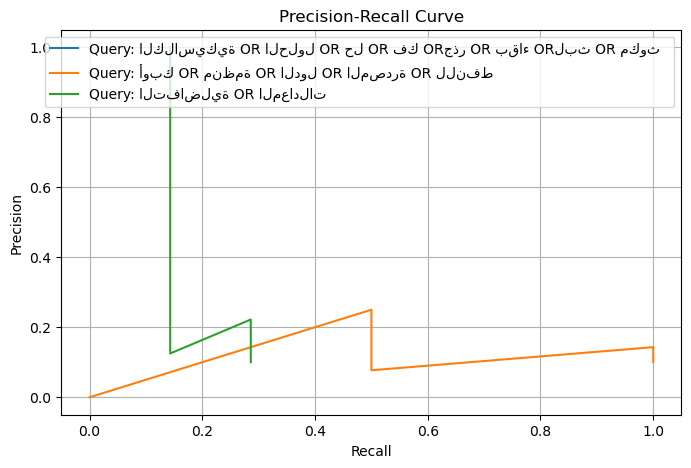

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the Precision-Recall Curve
def plot_precision_recall_curve(results, query):
    recalls = [result[3] for result in results]
    precisions = [result[4] for result in results]

    plt.plot(recalls, precisions, label=f'Query: {query}')

# Define the queries and relevant documents for each query
queries = [
    ("الكلاسيكية OR الحلول OR حل OR فك ORجذر OR بقاء ORلبث OR مكوث  ", []),
    ("أوبك OR منظمة OR الدول OR المصدرة OR للنفط ", ["D493 A.txt", "D330 A.txt"]),
    ("التفاضلية OR المعادلات", ["D508 A.txt", "D081 A.txt", "D105 A.txt", "D162 A.txt", "D329 A.txt", "D552 A.txt", "D464 A.txt"])
]
# Plot non-interpolated Precision-Recall Curve for each query
plt.figure(figsize=(8, 5))
for query, relevant_documents in queries:
    marked_results_query = search_vectorial(query, relevant_documents, limit=20)
    plot_precision_recall_curve(marked_results_query, query)

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
# ...

# Calculate average precision, F-measure, and precision at specific points
average_precisions = []
f_measures = []
precisions_at_points = {"P5": [], "P10": [], "P15": [], "P20": []}

# ...

# ...

# Assuming you have a list of transformed queries and relevant documents
queries = [
    ("الكلاسيكية OR الحلول OR حل OR فك ORجذر OR بقاء ORلبث OR مكوث  ", []),
    ("أوبك OR منظمة OR الدول OR المصدرة OR للنفط ", ["D493 A.txt", "D330 A.txt"]),
    ("التفاضلية OR المعادلات", ["D508 A.txt", "D081 A.txt", "D105 A.txt", "D162 A.txt", "D329 A.txt", "D552 A.txt", "D464 A.txt"])
]

# ...

# Calculate average precision, F-measure, and precision at specific points
average_precisions = []
f_measures = []
precisions_at_points = {"P5": [], "P10": [], "P15": [], "P20": []}

# ...

for query, relevant_documents in queries:
    marked_results_query = search_vectorial(query, relevant_documents, limit=20)
    
    recall_values = [result[3] for result in marked_results_query]
    precision_values = [result[4] for result in marked_results_query]
    
    if recall_values and precision_values:
        average_precisions.append(calculate_average_precision(marked_results_query))
        f_measures.append(calculate_f_measure(precision_values[-1], recall_values[-1]))

        precisions_at_points["P5"].append(precision_values[min(4, len(precision_values)-1)])
        precisions_at_points["P10"].append(precision_values[min(9, len(precision_values)-1)])
        precisions_at_points["P15"].append(precision_values[min(14, len(precision_values)-1)])
        precisions_at_points["P20"].append(precision_values[min(19, len(precision_values)-1)])
    else:
        print(f"No results for query: '{query}'")

# ...

# Calculate overall averages
average_precision_overall = sum(average_precisions) / len(average_precisions)
f_measure_overall = sum(f_measures) / len(f_measures)
precision_at_points_overall = {point: sum(values) / len(values) for point, values in precisions_at_points.items()}

# Print the results
print('--------------------')
print(f"Average Precision: {average_precision_overall:.3f}")
print(f"F-measure: {f_measure_overall:.3f}")
print("Precision at specific points:")
for point, value in precision_at_points_overall.items():
    print(f"{point}: {value:.3f}")


No results for query: 'الكلاسيكية OR الحلول OR حل OR فك ORجذر OR بقاء ORلبث OR مكوث  '
--------------------
Average Precision: 0.176
F-measure: 0.165
Precision at specific points:
P5: 0.200
P10: 0.150
P15: 0.133
P20: 0.100


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meriem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


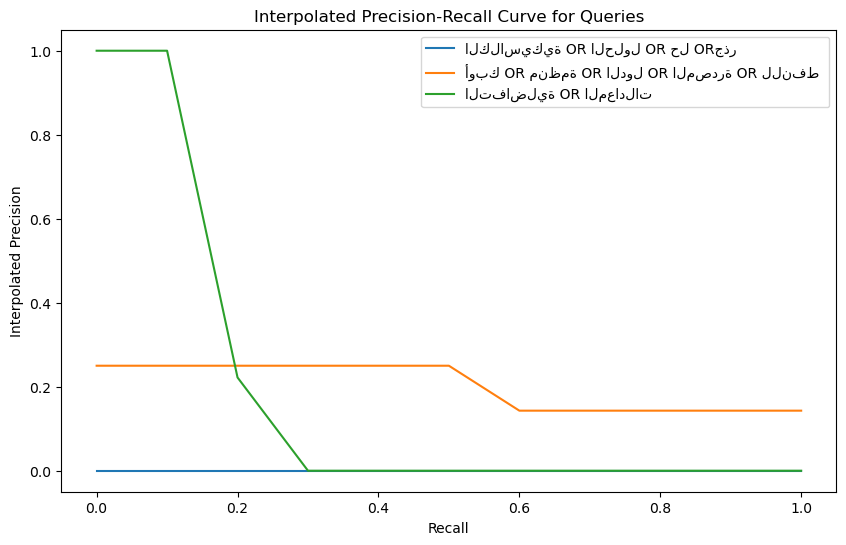

In [52]:
import csv
from whoosh.fields import Schema, TEXT, ID
from whoosh import index
from whoosh.analysis import RegexTokenizer, StopFilter, Filter
from whoosh.qparser import QueryParser
from nltk.stem.isri import ISRIStemmer
import os.path
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt

nltk.download('stopwords')

# Charger la liste des mots vides en arabe de NLTK
arabic_stopwords = set(stopwords.words("arabic"))

class ArabicStemFilter(Filter):
    def __init__(self):
        self.stemmer = ISRIStemmer()

    def __call__(self, tokens):
        for t in tokens:
            t.text = self.stemmer.stem(t.text)
            yield t

# Créer un analyseur personnalisé avec la liste des mots vides de NLTK
analyzer = RegexTokenizer() | StopFilter(stoplist=arabic_stopwords) | ArabicStemFilter()

# Créer le schéma en utilisant l'analyseur personnalisé
schema = Schema(
    title=TEXT(stored=True),
    path=ID(stored=True),
    content=TEXT(stored=True, analyzer=analyzer, vector=True)  # Ajouter "vector=True"
)

# Créer le répertoire d'index s'il n'existe pas
#if not os.path.exists("Index"):
 #   os.mkdir("Index")

# Lister les fichiers dans le répertoire "Corpus"
corpus_dir = "E:/M2/RI/Corpus/Corpus"
file_names = os.listdir(corpus_dir)

# Créer l'index avec le modèle BM25F
ix = index.create_in("Index-2", schema)  # Ajouter le paramètre weighting ici

# Indexer les documents avec prétraitement
with ix.writer() as writer:
    for file_name in file_names:
        with open(os.path.join(corpus_dir, file_name), 'r', encoding='windows-1256') as file:
            content = file.read()
            writer.add_document(title=file_name, content=content, path='')

# ...

# ...

# ...

# ...

def search_vectorial(query_str, relevant_documents, limit=20):
    with ix.searcher() as searcher:
        # Définir un analyseur et un parseur liés à l'index
        query_parser = QueryParser("content", ix.schema)
        query = query_parser.parse(query_str)

        # Recherche Vectorielle (utilisation par défaut de Whoosh)
        results_vectorial = searcher.search(query, terms=True, limit=limit)

        # Marquer les résultats en fonction de la liste des documents pertinents
        marked_results = []
        true_positives = 0  # Count of relevant documents retrieved
        false_positives = 0  # Count of irrelevant documents retrieved
        total_relevant_documents = len(relevant_documents)

        if total_relevant_documents == 0:
            recall = precision = 0
        else:
            for rank, r in enumerate(results_vectorial, start=1):
                is_relevant = r['title'] in relevant_documents
                mark = 'YES' if is_relevant else 'NO'

                # Calculate recall and precision for each document
                if is_relevant:
                    true_positives += 1
                else:
                    false_positives += 1

                recall = round(true_positives / total_relevant_documents, 3)
                precision = round(true_positives / (true_positives + false_positives), 3)

                # Append information to the marked result
                marked_results.append((rank, r['title'], mark, recall, precision))

        # Write detailed results to CSV
        csv_file_path = f"results_{query_str.replace(' ', '_')}.csv"
        with open(csv_file_path, mode='w', encoding='utf-8', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow(['Rang', 'document', 'Pertinent', 'Rappel', 'Precision'])
            csv_writer.writerows(marked_results)

        return marked_results

# ...



def calculate_interpolated_precision(results, recall_levels):
    recall_values = [result[3] for result in results]
    precision_values = [result[4] for result in results]

    interpolated_precisions = []
    for recall_level in recall_levels:
        max_precision = 0
        for recall, precision in zip(recall_values, precision_values):
            if recall >= recall_level:
                max_precision = max(max_precision, precision)
        interpolated_precisions.append(max_precision)

    return interpolated_precisions

# Define the queries and relevant documents for each query
queries = [
    ("الكلاسيكية OR الحلول OR حل ORجذر  ", []),
    ("أوبك OR منظمة OR الدول OR المصدرة OR للنفط ", ["D493 A.txt", "D330 A.txt"]),
    ("التفاضلية OR المعادلات", ["D508 A.txt", "D081 A.txt", "D105 A.txt", "D162 A.txt", "D329 A.txt", "D552 A.txt", "D464 A.txt"])
]

# Interpolated Precision Recall Curve
recall_levels = np.arange(0, 1.1, 0.1)
interpolated_precision_all_queries = []

# Rechercher et marquer les documents pertinents pour chaque requête
for query, relevant_documents in queries:
    marked_results_query = search_vectorial(query, relevant_documents, limit=20)
    interpolated_precision_query = calculate_interpolated_precision(marked_results_query, recall_levels)
    interpolated_precision_all_queries.append((query, interpolated_precision_query))

# Plot Interpolated Precision Recall Curve for all queries
plt.figure(figsize=(10, 6))
for query, interpolated_precision_query in interpolated_precision_all_queries:
    plt.plot(recall_levels, interpolated_precision_query, label=query)

plt.title('Interpolated Precision-Recall Curve for Queries')
plt.xlabel('Recall')
plt.ylabel('Interpolated Precision')
plt.legend()
plt.show()


In [53]:

# Provide the correct file path as a string
file_path = r'C:\Users\meriem\Documents\results_التفاضلية_OR_المعادلات.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Print the DataFrame
print(df)


    Rang    document Pertinent  Rappel  Precision
0      1  D162 A.txt       YES   0.143      1.000
1      2  D185 A.txt        NO   0.143      0.500
2      3  D334 A.txt        NO   0.143      0.333
3      4  D471 A.txt        NO   0.143      0.250
4      5  D468 A.txt        NO   0.143      0.200
5      6  D250 A.txt        NO   0.143      0.167
6      7  D560 A.txt        NO   0.143      0.143
7      8  D359 A.txt        NO   0.143      0.125
8      9  D329 A.txt       YES   0.286      0.222
9     10  D139 A.txt        NO   0.286      0.200
10    11  D264 A.txt        NO   0.286      0.182
11    12  D325 A.txt        NO   0.286      0.167
12    13  D062 A.txt        NO   0.286      0.154
13    14  D225 A.txt        NO   0.286      0.143
14    15  D551 A.txt        NO   0.286      0.133
15    16  D241 A.txt        NO   0.286      0.125
16    17  D568 A.txt        NO   0.286      0.118
17    18  D066 A.txt        NO   0.286      0.111
18    19  D289 A.txt        NO   0.286      0.105


In [54]:

# Provide the correct file path as a string
file_path = r'C:\Users\meriem\Documents\results_الكلاسيكية_OR_الحلول_OR_حل_ORجذر__.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Print the DataFrame
print(df)


Empty DataFrame
Columns: [Rang, document, Pertinent, Rappel, Precision]
Index: []


In [55]:
# Provide the correct file path as a string
file_path = r'C:\Users\meriem\Documents\results_أوبك_OR_منظمة_OR_الدول_OR_المصدرة_OR_للنفط_.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Print the DataFrame
print(df)


    Rang    document Pertinent  Rappel  Precision
0      1  D011 A.txt        NO     0.0      0.000
1      2  D035 A.txt        NO     0.0      0.000
2      3  D112 A.txt        NO     0.0      0.000
3      4  D330 A.txt       YES     0.5      0.250
4      5  D037 A.txt        NO     0.5      0.200
5      6  D298 A.txt        NO     0.5      0.167
6      7  D028 A.txt        NO     0.5      0.143
7      8  D506 A.txt        NO     0.5      0.125
8      9  D267 A.txt        NO     0.5      0.111
9     10  D483 A.txt        NO     0.5      0.100
10    11  D272 A.txt        NO     0.5      0.091
11    12  D027 A.txt        NO     0.5      0.083
12    13  D321 A.txt        NO     0.5      0.077
13    14  D493 A.txt       YES     1.0      0.143
14    15  D536 A.txt        NO     1.0      0.133
15    16  D301 A.txt        NO     1.0      0.125
16    17  D030 A.txt        NO     1.0      0.118
17    18  D227 A.txt        NO     1.0      0.111
18    19  D257 A.txt        NO     1.0      0.105


In [56]:
# ...

# Calculate average precision, F-measure, and precision at specific points
average_precisions = []
f_measures = []
precisions_at_points = {"P5": [], "P10": [], "P15": [], "P20": []}

# ...

# ...

# Assuming you have a list of transformed queries and relevant documents
queries = [
    ("الكلاسيكية OR الحلول OR حل ORجذر  ", []),
    ("أوبك OR منظمة OR الدول OR المصدرة OR للنفط ", ["D493 A.txt", "D330 A.txt"]),
    ("التفاضلية OR المعادلات", ["D508 A.txt", "D081 A.txt", "D105 A.txt", "D162 A.txt", "D329 A.txt", "D552 A.txt", "D464 A.txt"])
]


# ...

# Calculate average precision, F-measure, and precision at specific points
average_precisions = []
f_measures = []
precisions_at_points = {"P5": [], "P10": [], "P15": [], "P20": []}

# ...

for query, relevant_documents in queries:
    marked_results_query = search_vectorial(query, relevant_documents, limit=20)
    
    recall_values = [result[3] for result in marked_results_query]
    precision_values = [result[4] for result in marked_results_query]
    
    if recall_values and precision_values:
        average_precisions.append(calculate_average_precision(marked_results_query))
        f_measures.append(calculate_f_measure(precision_values[-1], recall_values[-1]))

        precisions_at_points["P5"].append(precision_values[min(4, len(precision_values)-1)])
        precisions_at_points["P10"].append(precision_values[min(9, len(precision_values)-1)])
        precisions_at_points["P15"].append(precision_values[min(14, len(precision_values)-1)])
        precisions_at_points["P20"].append(precision_values[min(19, len(precision_values)-1)])
    else:
        print(f"No results for query: '{query}'")

# ...

# Calculate overall averages
average_precision_overall = sum(average_precisions) / len(average_precisions)
f_measure_overall = sum(f_measures) / len(f_measures)
precision_at_points_overall = {point: sum(values) / len(values) for point, values in precisions_at_points.items()}

# Print the results
print('--------------------')
print(f"Average Precision: {average_precision_overall:.3f}")
print(f"F-measure: {f_measure_overall:.3f}")
print("Precision at specific points:")
for point, value in precision_at_points_overall.items():
    print(f"{point}: {value:.3f}")


No results for query: 'الكلاسيكية OR الحلول OR حل ORجذر  '
--------------------
Average Precision: 0.176
F-measure: 0.165
Precision at specific points:
P5: 0.200
P10: 0.150
P15: 0.133
P20: 0.100


-------------------------with scoring.TF_IDF()"original-querry"------------------------------------- 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meriem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


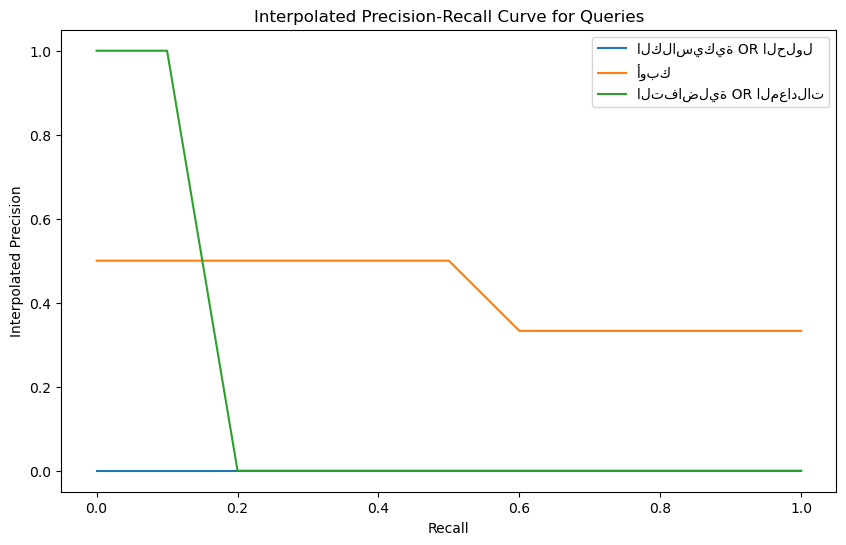

In [10]:
import csv
from whoosh.fields import Schema, TEXT, ID
from whoosh import index
from whoosh.analysis import RegexTokenizer, StopFilter, Filter
from whoosh.qparser import QueryParser
from whoosh import scoring
from nltk.stem.isri import ISRIStemmer
import os.path
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import nltk

nltk.download('stopwords')

# Charger la liste des mots vides en arabe de NLTK
arabic_stopwords = set(stopwords.words("arabic"))

class ArabicStemFilter(Filter):
    def __init__(self):
        self.stemmer = ISRIStemmer()

    def __call__(self, tokens):
        for t in tokens:
            t.text = self.stemmer.stem(t.text)
            yield t

# Créer un analyseur personnalisé avec la liste des mots vides de NLTK
analyzer = RegexTokenizer() | StopFilter(stoplist=arabic_stopwords) | ArabicStemFilter()

# Créer le schéma en utilisant l'analyseur personnalisé
schema = Schema(
    title=TEXT(stored=True),
    path=ID(stored=True),
    content=TEXT(stored=True, analyzer=analyzer, vector=True)  # Ajouter "vector=True"
)

# Créer le répertoire d'index s'il n'existe pas
if not os.path.exists("Index-2"):
    os.mkdir("Index-2")

# Lister les fichiers dans le répertoire "Corpus"
corpus_dir = "E:/M2/RI/Corpus/Corpus"
file_names = os.listdir(corpus_dir)

# Créer l'index
ix = index.create_in("Index-2", schema)

# Indexer les documents avec prétraitement
with ix.writer() as writer:
    for file_name in file_names:
        with open(os.path.join(corpus_dir, file_name), 'r', encoding='windows-1256') as file:
            content = file.read()
            writer.add_document(title=file_name, content=content, path='')

def calculate_interpolated_precision(results, recall_levels):
    recall_values = [result[3] for result in results]
    precision_values = [result[4] for result in results]

    interpolated_precisions = []
    for recall_level in recall_levels:
        max_precision = 0
        for recall, precision in zip(recall_values, precision_values):
            if recall >= recall_level:
                max_precision = max(max_precision, precision)
        interpolated_precisions.append(max_precision)

    return interpolated_precisions

def search_vectorial(query_str, relevant_documents, limit=20):
    with ix.searcher(weighting=scoring.TF_IDF()) as searcher:  # Use scoring module for TF-IDF
        # Définir un analyseur et un parseur liés à l'index
        query_parser = QueryParser("content", ix.schema)
        query = query_parser.parse(query_str)

        # Recherche Vectorielle (utilisation par défaut de Whoosh)
        results_vectorial = searcher.search(query, terms=True, limit=limit)

        # Marquer les résultats en fonction de la liste des documents pertinents
        marked_results = []
        true_positives = 0  # Count of relevant documents retrieved
        false_positives = 0  # Count of irrelevant documents retrieved
        total_relevant_documents = len(relevant_documents)

        if total_relevant_documents == 0:
            recall = precision = 0
        else:
            for rank, r in enumerate(results_vectorial, start=1):
                is_relevant = r['title'] in relevant_documents
                mark = 'YES' if is_relevant else 'NO'

                # Calculate recall and precision for each document
                if is_relevant:
                    true_positives += 1
                else:
                    false_positives += 1

                recall = round(true_positives / total_relevant_documents, 3)
                precision = round(true_positives / (true_positives + false_positives), 3)

                # Append information to the marked result
                marked_results.append((rank, r['title'], mark, recall, precision))

        return marked_results

# Define the queries and relevant documents for each query
queries = [
    ("الكلاسيكية OR الحلول", []),
    ("أوبك", ["D493 A.txt", "D330 A.txt"]),
    ("التفاضلية OR المعادلات", ["D508 A.txt", "D081 A.txt", "D105 A.txt", "D162 A.txt", "D329 A.txt", "D552 A.txt", "D464 A.txt"])
]

# Interpolated Precision Recall Curve
recall_levels = np.arange(0, 1.1, 0.1)
interpolated_precision_all_queries = []

# Rechercher et marquer les documents pertinents pour chaque requête
for query, relevant_documents in queries:
    marked_results_query = search_vectorial(query, relevant_documents, limit=20)
    interpolated_precision_query = calculate_interpolated_precision(marked_results_query, recall_levels)
    interpolated_precision_all_queries.append((query, interpolated_precision_query))

# Plot Interpolated Precision Recall Curve for all queries
plt.figure(figsize=(10, 6))
for query, interpolated_precision_query in interpolated_precision_all_queries:
    plt.plot(recall_levels, interpolated_precision_query, label=query)

plt.title('Interpolated Precision-Recall Curve for Queries')
plt.xlabel('Recall')
plt.ylabel('Interpolated Precision')
plt.legend()
plt.show()


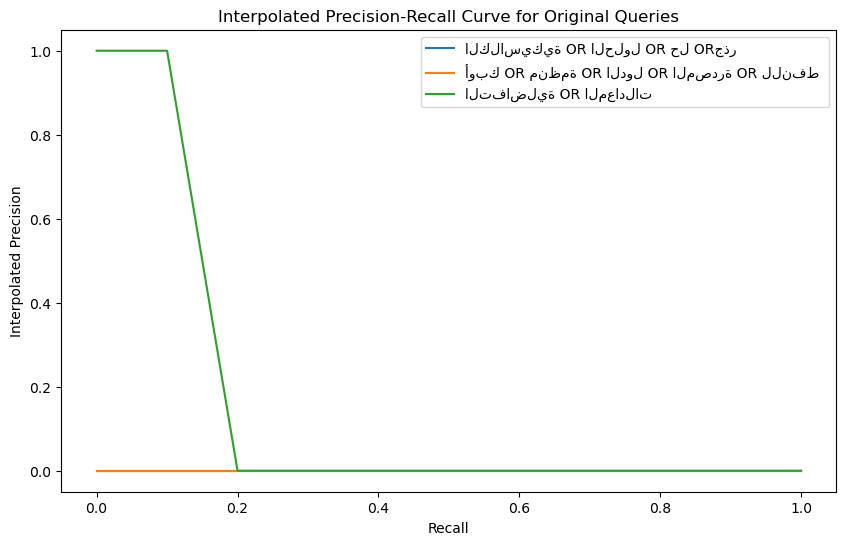

Results for Original Queries:
Average Precision: 0.061
Mean Average Precision (MAP): 0.061
Average F-measure: 0.000


In [5]:
# Define the original queries and relevant documents for each query
original_queries = [
    ("الكلاسيكية OR الحلول OR حل ORجذر  ", []),
    ("أوبك OR منظمة OR الدول OR المصدرة OR للنفط ", ["D493 A.txt", "D330 A.txt"]),
    ("التفاضلية OR المعادلات", ["D508 A.txt", "D081 A.txt", "D105 A.txt", "D162 A.txt", "D329 A.txt", "D552 A.txt", "D464 A.txt"])
]

# Interpolated Precision Recall Curve for original queries
recall_levels_original = np.arange(0, 1.1, 0.1)
interpolated_precision_all_queries_original = []

# Rechercher et marquer les documents pertinents pour chaque requête originale
for query, relevant_documents in original_queries:
    marked_results_query_original = search_vectorial(query, relevant_documents, limit=20)
    interpolated_precision_query_original = calculate_interpolated_precision(marked_results_query_original, recall_levels_original)
    interpolated_precision_all_queries_original.append((query, interpolated_precision_query_original))

# Plot Interpolated Precision Recall Curve for original queries
plt.figure(figsize=(10, 6))
for query, interpolated_precision_query_original in interpolated_precision_all_queries_original:
    plt.plot(recall_levels_original, interpolated_precision_query_original, label=query)

plt.title('Interpolated Precision-Recall Curve for Original Queries')
plt.xlabel('Recall')
plt.ylabel('Interpolated Precision')
plt.legend()
plt.show()

# Calculate average precision, MAP, and F-measure for original queries
average_precisions_all_queries_original = []
f_measures_all_queries_original = []

for _, interpolated_precision_query_original in interpolated_precision_all_queries_original:
    average_precision_query_original = calculate_average_precision(interpolated_precision_query_original)
    f_measure_query_original = calculate_f_measure(interpolated_precision_query_original[-1], recall_levels_original[-1])
    
    average_precisions_all_queries_original.append(average_precision_query_original)
    f_measures_all_queries_original.append(f_measure_query_original)

# Calculate overall average precision and MAP for original queries
average_precision_original = np.mean(average_precisions_all_queries_original)
map_value_original = calculate_map(interpolated_precision_all_queries_original)

# Print the results for original queries
print("Results for Original Queries:")
print(f"Average Precision: {average_precision_original:.3f}")
print(f"Mean Average Precision (MAP): {map_value_original:.3f}")
print(f"Average F-measure: {np.mean(f_measures_all_queries_original):.3f}")


---------------------tf-idf-transformated querries-----------------------------

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meriem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


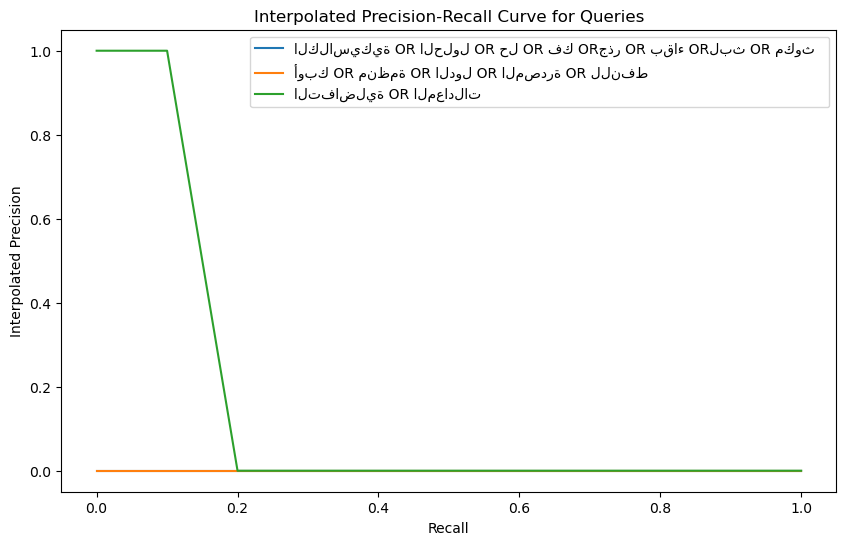

In [1]:
import csv
from whoosh.fields import Schema, TEXT, ID
from whoosh import index
from whoosh.analysis import RegexTokenizer, StopFilter, Filter
from whoosh.qparser import QueryParser
from whoosh import scoring
from nltk.stem.isri import ISRIStemmer
import os.path
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import nltk

nltk.download('stopwords')

# Charger la liste des mots vides en arabe de NLTK
arabic_stopwords = set(stopwords.words("arabic"))

class ArabicStemFilter(Filter):
    def __init__(self):
        self.stemmer = ISRIStemmer()

    def __call__(self, tokens):
        for t in tokens:
            t.text = self.stemmer.stem(t.text)
            yield t

# Créer un analyseur personnalisé avec la liste des mots vides de NLTK
analyzer = RegexTokenizer() | StopFilter(stoplist=arabic_stopwords) | ArabicStemFilter()

# Créer le schéma en utilisant l'analyseur personnalisé
schema = Schema(
    title=TEXT(stored=True),
    path=ID(stored=True),
    content=TEXT(stored=True, analyzer=analyzer, vector=True)  # Ajouter "vector=True"
)

# Créer le répertoire d'index s'il n'existe pas
if not os.path.exists("Index-2"):
    os.mkdir("Index-2")

# Lister les fichiers dans le répertoire "Corpus"
corpus_dir = "E:/M2/RI/Corpus/Corpus"
file_names = os.listdir(corpus_dir)

# Créer l'index
ix = index.create_in("Index-2", schema)

# Indexer les documents avec prétraitement
with ix.writer() as writer:
    for file_name in file_names:
        with open(os.path.join(corpus_dir, file_name), 'r', encoding='windows-1256') as file:
            content = file.read()
            writer.add_document(title=file_name, content=content, path='')

def calculate_interpolated_precision(results, recall_levels):
    recall_values = [result[3] for result in results]
    precision_values = [result[4] for result in results]

    interpolated_precisions = []
    for recall_level in recall_levels:
        max_precision = 0
        for recall, precision in zip(recall_values, precision_values):
            if recall >= recall_level:
                max_precision = max(max_precision, precision)
        interpolated_precisions.append(max_precision)

    return interpolated_precisions

def search_vectorial(query_str, relevant_documents, limit=20):
    with ix.searcher(weighting=scoring.TF_IDF()) as searcher:  # Use scoring module for TF-IDF
        # Définir un analyseur et un parseur liés à l'index
        query_parser = QueryParser("content", ix.schema)
        query = query_parser.parse(query_str)

        # Recherche Vectorielle (utilisation par défaut de Whoosh)
        results_vectorial = searcher.search(query, terms=True, limit=limit)

        # Marquer les résultats en fonction de la liste des documents pertinents
        marked_results = []
        true_positives = 0  # Count of relevant documents retrieved
        false_positives = 0  # Count of irrelevant documents retrieved
        total_relevant_documents = len(relevant_documents)

        if total_relevant_documents == 0:
            recall = precision = 0
        else:
            for rank, r in enumerate(results_vectorial, start=1):
                is_relevant = r['title'] in relevant_documents
                mark = 'YES' if is_relevant else 'NO'

                # Calculate recall and precision for each document
                if is_relevant:
                    true_positives += 1
                else:
                    false_positives += 1

                recall = round(true_positives / total_relevant_documents, 3)
                precision = round(true_positives / (true_positives + false_positives), 3)

                # Append information to the marked result
                marked_results.append((rank, r['title'], mark, recall, precision))

        return marked_results

# Define the queries and relevant documents for each query
queries = [
    ("الكلاسيكية OR الحلول OR حل OR فك ORجذر OR بقاء ORلبث OR مكوث  ", []),
    ("أوبك OR منظمة OR الدول OR المصدرة OR للنفط ", ["D493 A.txt", "D330 A.txt"]),
    ("التفاضلية OR المعادلات", ["D508 A.txt", "D081 A.txt", "D105 A.txt", "D162 A.txt", "D329 A.txt", "D552 A.txt", "D464 A.txt"])
]

# Interpolated Precision Recall Curve
recall_levels = np.arange(0, 1.1, 0.1)
interpolated_precision_all_queries = []

# Rechercher et marquer les documents pertinents pour chaque requête
for query, relevant_documents in queries:
    marked_results_query = search_vectorial(query, relevant_documents, limit=20)
    interpolated_precision_query = calculate_interpolated_precision(marked_results_query, recall_levels)
    interpolated_precision_all_queries.append((query, interpolated_precision_query))

# Plot Interpolated Precision Recall Curve for all queries
plt.figure(figsize=(10, 6))
for query, interpolated_precision_query in interpolated_precision_all_queries:
    plt.plot(recall_levels, interpolated_precision_query, label=query)

plt.title('Interpolated Precision-Recall Curve for Queries')
plt.xlabel('Recall')
plt.ylabel('Interpolated Precision')
plt.legend()
plt.show()


In [4]:
# Calculate average precision, MAP, and F-measure for all queries
average_precisions_all_queries = []
f_measures_all_queries = []

for _, interpolated_precision_query in interpolated_precision_all_queries:
    average_precision_query = calculate_average_precision(interpolated_precision_query)
    f_measure_query = calculate_f_measure(interpolated_precision_query[-1], recall_levels[-1])
    
    average_precisions_all_queries.append(average_precision_query)
    f_measures_all_queries.append(f_measure_query)

# Calculate overall average precision and MAP
average_precision = np.mean(average_precisions_all_queries)
map_value = calculate_map(interpolated_precision_all_queries)

# Print the results
print(f"Average Precision: {average_precision:.3f}")
print(f"Mean Average Precision (MAP): {map_value:.3f}")
print(f"Average F-measure: {np.mean(f_measures_all_queries):.3f}")


Average Precision: 0.061
Mean Average Precision (MAP): 0.061
Average F-measure: 0.000


In [ ]:
--------------------------tf-idf with transformated querries +validation 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meriem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


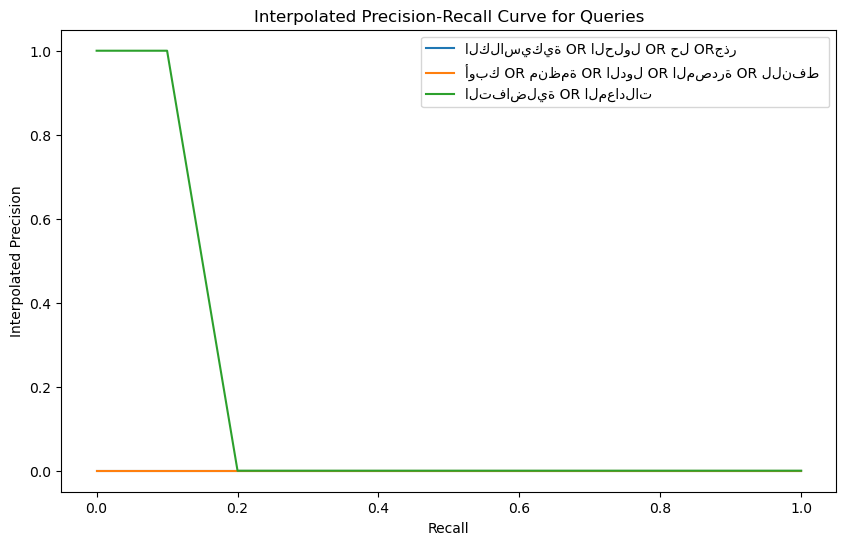

In [2]:
import csv
from whoosh.fields import Schema, TEXT, ID
from whoosh import index
from whoosh.analysis import RegexTokenizer, StopFilter, Filter
from whoosh.qparser import QueryParser
from whoosh import scoring
from nltk.stem.isri import ISRIStemmer
import os.path
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import nltk

nltk.download('stopwords')

# Charger la liste des mots vides en arabe de NLTK
arabic_stopwords = set(stopwords.words("arabic"))

class ArabicStemFilter(Filter):
    def __init__(self):
        self.stemmer = ISRIStemmer()

    def __call__(self, tokens):
        for t in tokens:
            t.text = self.stemmer.stem(t.text)
            yield t

# Créer un analyseur personnalisé avec la liste des mots vides de NLTK
analyzer = RegexTokenizer() | StopFilter(stoplist=arabic_stopwords) | ArabicStemFilter()

# Créer le schéma en utilisant l'analyseur personnalisé
schema = Schema(
    title=TEXT(stored=True),
    path=ID(stored=True),
    content=TEXT(stored=True, analyzer=analyzer, vector=True)  # Ajouter "vector=True"
)

# Créer le répertoire d'index s'il n'existe pas
if not os.path.exists("Index-2"):
    os.mkdir("Index-2")

# Lister les fichiers dans le répertoire "Corpus"
corpus_dir = "E:/M2/RI/Corpus/Corpus"
file_names = os.listdir(corpus_dir)

# Créer l'index
ix = index.create_in("Index-2", schema)

# Indexer les documents avec prétraitement
with ix.writer() as writer:
    for file_name in file_names:
        with open(os.path.join(corpus_dir, file_name), 'r', encoding='windows-1256') as file:
            content = file.read()
            writer.add_document(title=file_name, content=content, path='')

def calculate_interpolated_precision(results, recall_levels):
    recall_values = [result[3] for result in results]
    precision_values = [result[4] for result in results]

    interpolated_precisions = []
    for recall_level in recall_levels:
        max_precision = 0
        for recall, precision in zip(recall_values, precision_values):
            if recall >= recall_level:
                max_precision = max(max_precision, precision)
        interpolated_precisions.append(max_precision)

    return interpolated_precisions

def search_vectorial(query_str, relevant_documents, limit=20):
    with ix.searcher(weighting=scoring.TF_IDF()) as searcher:  # Use scoring module for TF-IDF
        # Définir un analyseur et un parseur liés à l'index
        query_parser = QueryParser("content", ix.schema)
        query = query_parser.parse(query_str)

        # Recherche Vectorielle (utilisation par défaut de Whoosh)
        results_vectorial = searcher.search(query, terms=True, limit=limit)

        # Marquer les résultats en fonction de la liste des documents pertinents
        marked_results = []
        true_positives = 0  # Count of relevant documents retrieved
        false_positives = 0  # Count of irrelevant documents retrieved
        total_relevant_documents = len(relevant_documents)

        if total_relevant_documents == 0:
            recall = precision = 0
        else:
            for rank, r in enumerate(results_vectorial, start=1):
                is_relevant = r['title'] in relevant_documents
                mark = 'YES' if is_relevant else 'NO'

                # Calculate recall and precision for each document
                if is_relevant:
                    true_positives += 1
                else:
                    false_positives += 1

                recall = round(true_positives / total_relevant_documents, 3)
                precision = round(true_positives / (true_positives + false_positives), 3)

                # Append information to the marked result
                marked_results.append((rank, r['title'], mark, recall, precision))

        return marked_results

# Define the queries and relevant documents for each query
queries = [
    ("الكلاسيكية OR الحلول OR حل ORجذر  ", []),
    ("أوبك OR منظمة OR الدول OR المصدرة OR للنفط ", ["D493 A.txt", "D330 A.txt"]),
    ("التفاضلية OR المعادلات", ["D508 A.txt", "D081 A.txt", "D105 A.txt", "D162 A.txt", "D329 A.txt", "D552 A.txt", "D464 A.txt"])
]

# Interpolated Precision Recall Curve
recall_levels = np.arange(0, 1.1, 0.1)
interpolated_precision_all_queries = []

# Rechercher et marquer les documents pertinents pour chaque requête
for query, relevant_documents in queries:
    marked_results_query = search_vectorial(query, relevant_documents, limit=20)
    interpolated_precision_query = calculate_interpolated_precision(marked_results_query, recall_levels)
    interpolated_precision_all_queries.append((query, interpolated_precision_query))

# Plot Interpolated Precision Recall Curve for all queries
plt.figure(figsize=(10, 6))
for query, interpolated_precision_query in interpolated_precision_all_queries:
    plt.plot(recall_levels, interpolated_precision_query, label=query)

plt.title('Interpolated Precision-Recall Curve for Queries')
plt.xlabel('Recall')
plt.ylabel('Interpolated Precision')
plt.legend()
plt.show()


In [3]:
def calculate_average_precision(interpolated_precisions):
    return np.mean(interpolated_precisions)

def calculate_map(interpolated_precisions_all_queries):
    return np.mean([calculate_average_precision(query_precisions) for _, query_precisions in interpolated_precisions_all_queries])

def calculate_f_measure(precision, recall, beta=1):
    if precision + recall == 0:
        return 0
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

# Calculate average precision, MAP, and F-measure for all queries
average_precisions_all_queries = []
f_measures_all_queries = []

for _, interpolated_precision_query in interpolated_precision_all_queries:
    average_precision_query = calculate_average_precision(interpolated_precision_query)
    f_measure_query = calculate_f_measure(interpolated_precision_query[-1], recall_levels[-1])
    
    average_precisions_all_queries.append(average_precision_query)
    f_measures_all_queries.append(f_measure_query)

# Calculate overall average precision and MAP
average_precision = np.mean(average_precisions_all_queries)
map_value = calculate_map(interpolated_precision_all_queries)

# Print the results
print(f"Average Precision: {average_precision:.3f}")
print(f"Mean Average Precision (MAP): {map_value:.3f}")
print(f"Average F-measure: {np.mean(f_measures_all_queries):.3f}")


Average Precision: 0.061
Mean Average Precision (MAP): 0.061
Average F-measure: 0.000
